### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
from neuropy.utils.ccg import correlograms
from tqdm.notebook import tqdm
from neuropy.core import Epoch

import subjects

### Interneuron categorization based on firing rate around ripples start
- using CCG algorithm

In [ ]:
acgs = []
bin_size = 0.01
window_size = 0.2
n_bins = int(window_size // bin_size)
for sub, sess in enumerate(sessions):
    ripple = sess.ripple.to_dataframe().peaktime.values
    neurons = sess.neurons.get_neuron_type("inter")
    for s in neurons.spiketrains:
        combined_s = np.concatenate((s, ripple))
        combined_id = np.concatenate(
            (np.ones(len(s)), 2 * np.ones(len(ripple)))
        ).astype("int")
        sort_ind = np.argsort(combined_s)
        acg = correlograms(
            combined_s[sort_ind],
            combined_id[sort_ind],
            sample_rate=30000,
            bin_size=bin_size,
            window_size=window_size,
        )
        acgs.append(acg[0, 1, :])

acgs = np.asarray(acgs)
t_bin = np.linspace(-n_bins // 2, n_bins // 2, acgs.shape[1])
data = pd.DataFrame(stats.zscore(acgs, axis=1), columns=t_bin)
data["neuron"] = np.arange(acgs.shape[0])
data = pd.melt(
    data,
    id_vars=["neuron"],
    value_vars=t_bin,
    var_name=["time"],
    value_name="frate",
    ignore_index=True,
)

In [ ]:
%matplotlib widget
import seaborn as sns

_,axs = plt.subplots(10,9,sharex=True,sharey=True)
axs = axs.reshape(-1)

acgs_norm = acgs/np.sum(acgs,axis=1,keepdims=True)

for i,a in enumerate(acgs_norm):

    axs[i].fill_between(t_bin,0,a)


# from neuropy.core import Ratemap

# rmap = Ratemap(acgs,np.arange(52),neuron_ids=np.arange(acgs.shape[0]))
# plotting.plot_ratemap(rmap,normalize_tuning_curve=True,pad=2)

# sns.catplot(data=data,x='time',y='frate',col='neuron',col_wrap=5,kind='bar')
# sns.relplot(data=data,x='time',y='frate',col='neuron',col_wrap=5,kind='line')

### Interneurons categorization based on ripple modulation
- The method here is similar to Diba et.al. 2014.
- Here the code that worked and shows some kmeans clustering to identify different categories.
- NOTE: The main has now been ported to ripple_funcs.py in the current directory

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
from neuropy.utils.ccg import correlograms
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4
    # + subjects.sd.ratVday2
    # + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    # + subjects.nsd.ratVday1
)


In [ ]:
from sklearn.cluster import KMeans
from ripple_funcs import ripple_modulation

frate_around_rpl = []
for sub, sess in enumerate(sessions):
    neurons = sess.neurons.get_neuron_type("inter")
    n_neurons = len(neurons)
    ripples = sess.ripple.to_dataframe()

    start, peak, stop = sess.ripple.to_dataframe()[
        ["start", "peaktime", "stop"]
    ].values.T
    modulation = ripple_modulation(neurons, start, peak, stop, n_bins=4)
    frate_around_rpl.append(modulation)

frate_around_rpl = np.vstack(frate_around_rpl)
frate_norm = frate_around_rpl / np.sum(frate_around_rpl, axis=1, keepdims=True)
kmeans = KMeans(n_clusters=2, random_state=0).fit(frate_norm)


#### PCA projection of interneurons modulation

In [ ]:
from sklearn.decomposition import PCA
from neuropy import plotting

pca = PCA(n_components=2)
pca.fit(frate_norm)
projected = pca.fit_transform(frate_norm)

# figure = plotting.Fig()
# fig,gs = figure.draw(grid=(1,2))
# gs_ = figure.subplot2grid(gs[1],grid=(2,1))
fig = plt.figure(figsize=(12, 5))
subfigs = fig.subfigures(1, 2, wspace=0.7)
ax_pca = subfigs[0].subplots(1, 1)
ax_pca.set_xlabel("PC1")
ax_pca.set_ylabel("PC2")

hist_figs = subfigs[1].subfigures(2, 1)

colors = ["r", "k"]
for label in [0, 1]:
    indices = kmeans.labels_ == label
    ax_pca.scatter(projected[indices, 0], projected[indices, 1], c=colors[label])

    ind_subset = np.random.choice(np.where(indices)[0], 8)
    frate_subset = frate_norm[ind_subset]
    ax_hists = hist_figs[label].subplots(2, 4, sharex=True, sharey=True).reshape(-1)
    for i, f in enumerate(frate_subset):
        ax_hists[i].stairs(f, np.arange(-8, 9), color=colors[label], fill=True)
        ax_hists[i].set_xticks([-5, 0, 5])
        ax_hists[i].set_xticklabels([-1, 0, 1])

# fig.savefig(subjects.figpath_sd/'interneuron_ripple_classification.pdf')


### Frate Inside/Outside ripples during SD and NSD

In [3]:
sessions = subjects.mua_sess()

In [15]:
print(f"#Sessions: {len(sessions)}")
frate_df = []
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    pre = [np.max([pre[0], pre[1] - 2.5 * 3600]), pre[1]]
    maze = sess.paradigm["maze"]
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons_stable.get_neuron_type(["pyr", "inter"])
    spktrns = neurons.spiketrains

    # --- 5 minutes------
    # post_starts = np.arange(post[0],post[0]+8*3600,300)
    # zts = (post_starts - post[0])/3600
    # post_stops = post_starts+300
    # post_labels = [f'{a}' for a in zts]

    # --- hourly ------
    # post_starts = np.arange(9) * 3600 + post[0]
    # post_labels = [f"{_}-{_+1}" for _ in range(len(post_starts))]

    # ---- 2.5 hours
    zts = np.array([0, 2.5, 5])
    post_starts = zts * 3600 + post[0]
    post_stops = post_starts + 2.5 * 3600
    post_labels = [f"{a}-{a+2.5}" for a in zts]

    # NOTE: subtracted 0.1 to keep the bins monotonically increasing
    post_epochs = Epoch.from_array(post_starts, post_stops - 0.1, post_labels)
    pre_epochs = Epoch.from_array([pre[0]],[pre[1]],'pre')

    # all_epochs = pre + maze + post_epochs
    all_epochs = pre_epochs + post_epochs

    # --- in ripples --------
    rpls = sess.ripple.time_slice(pre[0], post[0] + 8 * 3600)
    n_spikes = np.asarray(
        [np.histogram(spk, bins=rpls.flatten())[0] for spk in spktrns]
    )
    in_rpl_spikes = n_spikes[:, ::2]  # individual ripples

    # summing individual ripples within epochs
    in_rpl_spikes_epochs = stats.binned_statistic(
        rpls.starts, in_rpl_spikes, bins=all_epochs.flatten(), statistic="sum"
    )[0][:, ::2]

    n_rpls = np.histogram(rpls.starts, bins=all_epochs.flatten())[0][::2][np.newaxis, :]
    total_rpl_duration_epochs = stats.binned_statistic(
        rpls.starts, rpls.durations, bins=all_epochs.flatten(), statistic="sum"
    )[0][::2]

    # NOTE: divide by n_rpls or divide by total duration ??
    in_rpl_frate_epochs = (
        in_rpl_spikes_epochs / total_rpl_duration_epochs[np.newaxis, :]
    )
    # relative to PRE
    in_rpl_frate_epochs /= in_rpl_frate_epochs[:, 0, np.newaxis]

    # --- out ripples --------
    n_spikes_epochs = []
    for ep in all_epochs.itertuples():
        n_spikes_epochs.append(neurons.time_slice(ep.start, ep.stop).n_spikes)
    n_spikes_epochs = np.array(n_spikes_epochs).T
    out_rpl_spikes_epochs = n_spikes_epochs - in_rpl_spikes_epochs
    out_rpl_duration_epochs = (
        all_epochs.durations.astype("float") - total_rpl_duration_epochs
    )
    out_rpl_frate_epochs = (
        out_rpl_spikes_epochs / out_rpl_duration_epochs[np.newaxis, :]
    )

    # relative to PRE
    out_rpl_frate_epochs /= out_rpl_frate_epochs[:, 0, np.newaxis]

    # ----- Normalization ----------
    in_rpl_zscore = stats.zscore(in_rpl_frate_epochs, axis=1)
    out_rpl_zscore = stats.zscore(out_rpl_frate_epochs, axis=1)

    # baseline = in_rpl[:, 0, np.newaxis]
    # in_rpl = in_rpl - baseline
    # in_rpl = (zt_spikes_in - baseline) / baseline
    assert in_rpl_zscore.shape[0] == len(spktrns), "booo"
    assert out_rpl_zscore.shape[0] == len(spktrns), "booo hoo"

    in_rpl_df = pd.DataFrame(in_rpl_frate_epochs*100, columns=all_epochs.labels)
    in_rpl_df["where"] = "inside"
    in_rpl_df["neuron_type"] = neurons.neuron_type
    in_rpl_df["grp"] = sess.tag

    out_rpl_df = pd.DataFrame(out_rpl_frate_epochs*100, columns=all_epochs.labels)
    out_rpl_df["where"] = "outside"
    out_rpl_df["neuron_type"] = neurons.neuron_type
    out_rpl_df["grp"] = sess.tag

    frate_sub_df = pd.concat([in_rpl_df, out_rpl_df], axis=0, ignore_index=True)
    frate_df.append(frate_sub_df)

frate_df = pd.concat(frate_df, ignore_index=True)
frate_df = pd.melt(
    frate_df,
    id_vars=["where", "neuron_type", "grp"],
    value_vars=all_epochs.labels,
    var_name="zt",
    value_name="frate",
    ignore_index=True,
)

frate_df = frate_df[frate_df.zt!='pre'].reset_index(drop=True)
subjects.GroupData().save(frate_df, "frate_in_ripple")


#Sessions: 15


  0%|          | 0/15 [00:00<?, ?it/s]

frate_in_ripple saved


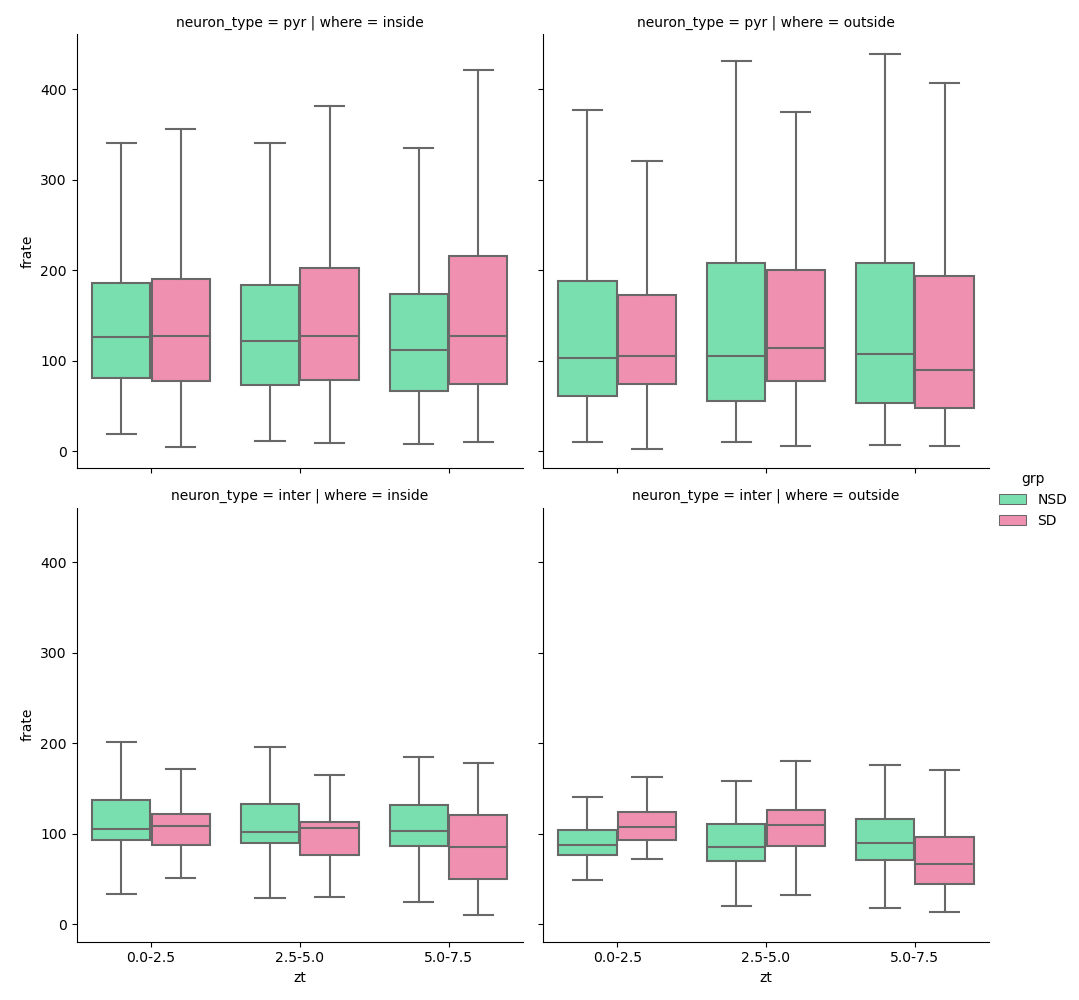

In [16]:
import seaborn as sns

g = sns.catplot(
    data=frate_df,
    x="zt",
    y="frate",
    hue="grp",
    col="where",
    row="neuron_type",
    kind="box",
    palette=["#69F0AE", "#FF80AB"],
    dodge=True,
    showfliers=False,
    # ci=95,
    # capsize=0.1,
)
axes = g.axes[0]
# [ax.set_yscale('log') for ax in axes]


### Firing rate (scatter plot) within and outside ripples during SD and NSD

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.sd.ratRday2

    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)

In [ ]:
from neuropy.core import Epoch
from neuropy.utils.mathutil import min_max_scaler

in_rpl,out_rpl,time =[],[],[]
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons.get_neuron_type("pyr")
    spktrns = neurons.spiketrains
    starts = np.arange(9) * 3600 + post[0]

    rpls = sess.ripple.time_slice(post[0],post[0]+9*3600).flatten()

    n_spikes = np.asarray([np.histogram(spk,bins=rpls)[0] for spk in spktrns])
    in_rpl.append(n_spikes[:,::2])
    out_rpl.append(n_spikes[:,1::2])
    time.append(rpls[::2]-post[0])


# frate_df = pd.melt(
#     frate_df,
#     id_vars=["rpl", "grp"],
#     value_vars=np.arange(1,9),
#     var_name="Zt time",
#     value_name="frate",
#     ignore_index=True,
# )


In [ ]:
%matplotlib widget
import seaborn as sns

data = stats.zscore(in_rpl[0],axis=1)
for i in range(97):
    plt.plot(time[0],data[i],'k.')

### PSTH around start of ripples during sleep deprivation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4

    +subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratUday2
)

In [ ]:
from neuropy.core import Epoch

frate_around_rpl,grp_info = [],[]
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons.get_neuron_type("pyr")
    grp_info.extend([sess.tag] * len(neurons))

    get_modulation = lambda e: neurons.get_modulation_in_epochs(e, 2)

    hour_modulation = []
    for t in [post[0], post[0] + 4 * 3600]:
        ripples = sess.ripple.time_slice(t, t + 3600)
        start, peak = ripples.to_dataframe()[["start", "peak_time"]].values.T
        start_peak_dur = peak - start
        epochs = Epoch.from_array(start - start_peak_dur, start + start_peak_dur)

        modulation = []
        for s in range(3):
            epoch_slices = epochs[s::3]  # [_[s::3] for _ in (pre_start, start_peak)]
            modulation.append(get_modulation(epoch_slices))
        hour_modulation.append(np.dstack(modulation).sum(axis=2)/ripples.durations.sum())

    frate_around_rpl.append(np.hstack(hour_modulation))

frate_around_rpl = np.vstack(frate_around_rpl)
# frate_norm = frate_around_rpl / np.sum(frate_around_rpl, axis=1, keepdims=True)
frate_norm = stats.zscore(frate_around_rpl, axis=1)

# bins = np.arange(-8, 9)
frate_rpl_df = pd.DataFrame(
    frate_around_rpl, columns=["pre_1h", "post_1h", "pre_5h", "post_5h"]
)
frate_rpl_df["grp"] = grp_info

# frate_session_df = pd.melt(
#     frate_session_df,
#     id_vars=["grp", "label"],
#     value_vars=time_bin,
#     var_name=["time"],
#     value_name="frate",
#     ignore_index=True,
# )


In [ ]:
import seaborn as sns

fig= plotting.Fig(grid=(2,2))

for i,grp in enumerate(['SD','NSD']):
    df = frate_rpl_df[frate_rpl_df['grp']==grp]

    ax_pre = plt.subplot(fig.gs[i,0])
    sns.scatterplot(data=df ,x='pre_1h',y='pre_5h',ax=ax_pre)
    ax_pre.set_xscale('log')
    ax_pre.set_yscale('log')
    ax_pre.axline((0,0),(1,1))


    ax_post = plt.subplot(fig.gs[i,1])
    sns.scatterplot(data=df ,x='post_1h',y='post_5h',ax=ax_post)
    ax_post.set_xscale('log')
    ax_post.set_yscale('log')
    ax_post.axline((0,0),(1,1))


### Percentage of Cells firing during ripples

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4

    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratUday2
)

In [ ]:
for sub,sess in enumerate(sessions):
    post = sess.paradigm['post'].flatten()
    neurons = sess.neurons.get_neuron_type('pyr')
    rpls = sess.ripple.time_slice(post[0],post[0]+3600)
    modulation = neurons.get_modulation_in_epochs(rpls,n_bins=1).reshape(-1)
    firing_cells = np.where(modulation>0)[0]
    perc = len(firing_cells)/len(modulation)
    print(perc)

### Neurons/MUA acg/ccg during ripples compared early to late of POST for SD and NSD
- I observed change in ripple frequency from early to late sleep. One possibility could be change in synchrony from early to late sleep. For example, in early sleep, neurons are firing in sequences during ripples but later most neurons cofire at same time at a little longer time lag. So here I am plotting acg/ccg or similar measure for change in spiketimes synchrony.
- Didn't find anything interesting in pyramidal neurons but for interneurons if CCGs are sorted by their peak time then Zt2 is more similar to Zt1 compared to Zt5. Probably this is expected

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import subjects
sessions = subjects.nsd.ratNday2+ subjects.nsd.ratSday2+subjects.nsd.ratUday2

In [ ]:
from neuropy.utils.ccg import correlograms

acg_zt1_all = []
acg_zt5_all = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons.get_neuron_type("inter")

    acg_zt = []
    firing_neurons = []
    for t in [post[0],post[0]+4*3600]:
        neurons_t = neurons.time_slice(t, t + 3600)
        n_id = neurons.neuron_ids
        spks = np.concatenate(neurons_t.spiketrains)
        spks_id = np.concatenate(
            [i * np.ones_like(_) for i, _ in zip(n_id, neurons_t.spiketrains)]
        ).astype("int")
        rpl_t = sess.ripple.time_slice(t, t + 3600).flatten()
        spk_bin_ind = np.digitize(spks, rpl_t)
        rpl_indx = spk_bin_ind % 2 == 1
        spks_in_rpl = spks[rpl_indx]
        spks_in_rpl_id = spks_id[rpl_indx]
        sort_ind = np.argsort(spks_in_rpl)
        acg = correlograms(
            spks_in_rpl[sort_ind],
            spks_in_rpl_id[sort_ind],
            sample_rate=30000,
            bin_size=0.001,
            window_size=0.3,
        )
        firing_neurons.append(np.unique(spks_in_rpl_id))
        acg_zt.append(acg)
    _, this, that = np.intersect1d(
        firing_neurons[0], firing_neurons[1], assume_unique=True, return_indices=True
    )

    pairs = np.tril_indices(len(this),k=-1)
    acg_zt = [
        acg_zt[i][np.ix_(ind, ind, np.arange(301))]
        for i, ind in enumerate([this, that])
    ]

    acg_zt = [stats.zscore(_[pairs[0], pairs[1], :],axis=1) for _ in acg_zt]
    nan_indices = np.bitwise_or(*[np.isnan(np.sum(_,axis=1)) for _ in acg_zt])

    acg_zt = [_[~nan_indices,:] for _ in acg_zt]
    acg_zt1_all.append(acg_zt[0])
    acg_zt5_all.append(acg_zt[1])

acg_zt1_all = np.vstack(acg_zt1_all)
acg_zt5_all = np.vstack(acg_zt5_all)

sort_ind = np.argsort(np.argmax(acg_zt1_all,axis=1))

In [ ]:
%matplotlib widget
fig,ax = plt.subplots(1,2)
for i,c in enumerate([acg_zt1_all,acg_zt5_all]):
    ax[i].pcolormesh(c[sort_ind,:])

### Spike triggered raster plot w.r.t ripples during sleep deprivation for individual neurons

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import subjects

sessions = subjects.sd.ratSday3

In [ ]:
for sub,sess in enumerate(sessions):
    sd = sess.paradigm['sd']
    rpls = sess.ripple.time_slice(sd[0],sd[1])
    

### Within ripple pairwise correlation comaparison between MAZE vs POST for SD and RS sessions 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
import subjects

sessions = subjects.sd.pf_sess + subjects.nsd.pf_sess

In [ ]:
import pingouin as pg
pcorr_df = []
for sub, sess in enumerate(sessions):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    zt5 = [post[0], post[0] + 5 * 3600]

    rpls_pre = sess.ripple.time_slice(*pre)
    rpls_maze = sess.ripple.time_slice(*maze)
    rpls_zt5 = sess.ripple.time_slice(*zt5)

    neurons = sess.neurons.get_neuron_type("pyr")

    indices = np.tril_indices(len(neurons), k=-1)
    pcorr = lambda e: np.corrcoef(np.hstack(neurons.get_spikes_in_epochs(e)[0]))[
        indices
    ]
    residual= lambda x,y: pg.linear_regression(x,y,remove_na=True).residuals_

    df = pd.DataFrame(
        dict(
            pre=pcorr(rpls_pre),
            maze=pcorr(rpls_maze),
            zt5=pcorr(rpls_zt5),
            grp=sess.tag,
        )
    )
    df.dropna(inplace=True)

    df['maze_residuals'] = residual(df['pre'],df['maze'])
    df['zt5_residuals'] = residual(df['pre'],df['zt5'])
    pcorr_df.append(df)

pcorr_df = pd.concat(pcorr_df, ignore_index=True)


In [ ]:
mat = pcorr_df[pcorr_df['grp']=='sd']
pg.partial_corr(mat,x='maze',y='zt5',covar='pre')

In [ ]:
mat = pcorr_df[pcorr_df['grp']=='nsd']
pg.partial_corr(mat,x='maze',y='zt5',covar='pre')

In [ ]:
%matplotlib widget
import seaborn as sns

sns.lmplot(data=pcorr_df,x='maze_residuals',y='zt5_residuals',col='grp',kind='hex')

### Neurons firing relative to ripples conserved during POST, SD vs NSD

In [ ]:
sessions = subjects.nsd.pf_sess

In [ ]:
from neuropy.core import Epoch
from scipy.ndimage import gaussian_filter1d

smooth = lambda arr: gaussian_filter1d(arr,2,axis=1)
maze_modulation, post_modulation = [], []
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("inter")
    grp_info.extend([sess.tag] * len(neurons))

    maze_rpls = sess.ripple.time_slice(*maze)
    post_rpls = sess.ripple.time_slice(post[0]+0*3600, post[0] + 5*3600)

    def modulation_(epochs: Epoch):
        get_modulation = lambda e: neurons.get_modulation_in_epochs(e, 60)
        epochs = Epoch.from_array(epochs.starts - 0.05, epochs.starts + 0.100)

        modulation = []
        for s in range(3):
            epoch_slices = epochs[s::3]  # [_[s::3] for _ in (pre_start, start_peak)]
            modulation.append(get_modulation(epoch_slices))
        return np.dstack(modulation).sum(axis=2)

    maze_modulation.append(modulation_(maze_rpls))
    post_modulation.append(modulation_(post_rpls))

maze_modulation = smooth(stats.zscore(np.vstack(maze_modulation), axis=1))
post_modulation = smooth(stats.zscore(np.vstack(post_modulation), axis=1))


In [ ]:
plt.clf()
_,axs = plt.subplots(1,2,sharey=True)

sort_ind = np.argsort(np.argmax(maze_modulation,axis=1))

for i,m in enumerate([maze_modulation,post_modulation]):
    axs[i].pcolormesh(m[sort_ind,:],cmap='jet')


## REMAZE

### Neurons firing relative to ripples conserved during remaze, SD vs NSD

In [ ]:
sessions = subjects.remaze_sess()

In [ ]:
from neuropy.core import Epoch
from scipy.ndimage import gaussian_filter1d

smooth = lambda arr: gaussian_filter1d(arr,2,axis=1)

grp_modulation =  dict(SD=dict(maze=[],remaze=[]),NSD=dict(maze=[],remaze=[]))
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("inter")

    maze_rpls = sess.ripple.time_slice(*maze)
    remaze_rpls = sess.ripple.time_slice(*remaze)

    def modulation_(epochs: Epoch):
        get_modulation = lambda e: neurons.get_modulation_in_epochs(e, 60)
        epochs = Epoch.from_array(epochs.starts - 0.05, epochs.starts + 0.100)

        modulation = []
        for s in range(3):
            epoch_slices = epochs[s::3]  # [_[s::3] for _ in (pre_start, start_peak)]
            modulation.append(get_modulation(epoch_slices))
        return np.dstack(modulation).sum(axis=2)

    grp_modulation[sess.tag]['maze'].append(modulation_(maze_rpls))
    grp_modulation[sess.tag]['remaze'].append(modulation_(remaze_rpls))

In [ ]:
from neuropy.utils.mathutil import min_max_scaler

fig = plotting.Fig(grid=(8, 7))
# _,axs = plt.subplots(2,2,sharey='row',sharex=True)

norm_smth = lambda g, s: smooth(stats.zscore(np.vstack(grp_modulation[g][s]), axis=1))
t = np.linspace(-50, 100, 60)
sort_where = t > 0

for i, grp in enumerate(["NSD", "SD"]):

    maze_modulation = norm_smth(grp, "maze")
    maze_peak = np.argmax(maze_modulation[:, sort_where], axis=1)
    remaze_modulation = norm_smth(grp, "remaze")
    remaze_peak = np.argmax(remaze_modulation[:, sort_where], axis=1)

    corr = stats.spearmanr(maze_peak, remaze_peak)
    print(corr)

    sort_ind = np.argsort(maze_peak)

    y = np.arange(maze_modulation.shape[0])
    for i1, m in enumerate([maze_modulation, remaze_modulation]):
        ax = fig.subplot(fig.gs[i, i1])
        pcm = ax.pcolormesh(
            t, y, m[sort_ind, :], cmap="jet", vmin=-0.5, vmax=1.5, rasterized=True
        )
        ax.axvline(0, ls="--", color="w")
        ax.set_xlabel("Time (ms)")
        ax.set_title(grp)

cax = fig.fig.add_axes([0.5, 0.75, 0.01, 0.1])
fig.fig.colorbar(pcm, cax=cax, shrink=0.6)

# fig.savefig(subjects.figpath_sd / "pyr_relative_swr_onset")